In [1]:
!pip install shap


In [2]:
!pip install lightgbm


In [1]:
import pandas as pd
import joblib
import shap
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [2]:
df = pd.read_csv(r"C:\Users\ADMIN\Desktop\ipl_score\data\processed\dataset.csv")
print(df.columns.tolist())


['batter', 'date', 'venue', 'bowling_team', 'rolling_avg_5', 'venue_avg', 'pvt_avg', 'pvp_avg', 'career_avg', 'next_match_runs', 'bowler', 'batting_team', 'rolling_wkts_5', 'bowler_venue_avg', 'bowler_career_avg', 'bowler_vs_team_avg', 'next_match_wicket']


In [3]:
#Runs
X_runs = df[
    ['rolling_avg_5', 'venue_avg', 'pvt_avg', 'pvp_avg', 'career_avg']
]

y_runs = df['next_match_runs']



In [4]:
#wickets
X_wickets = df[
    ['rolling_wkts_5', 'bowler_venue_avg', 'pvt_avg', 'pvp_avg',
     'bowler_career_avg', 'bowler_vs_team_avg']
]

y_wickets = df['next_match_wicket']


In [5]:
split = int(len(df) * 0.8)

# Runs
Xr_train, Xr_test = X_runs[:split], X_runs[split:]
yr_train, yr_test = y_runs[:split], y_runs[split:]

# Wickets
Xw_train, Xw_test = X_wickets[:split], X_wickets[split:]
yw_train, yw_test = y_wickets[:split], y_wickets[split:]


In [6]:
# Baseline prediction using rolling runs average
baseline_pred_runs = Xr_test['rolling_avg_5']

baseline_rmse_runs = np.sqrt(mean_squared_error(yr_test, baseline_pred_runs))
baseline_mae_runs  = mean_absolute_error(yr_test, baseline_pred_runs)
baseline_r2_runs   = r2_score(yr_test, baseline_pred_runs)

print("Baseline RMSE (Runs):", baseline_rmse_runs)
print("Baseline MAE (Runs):", baseline_mae_runs)
print("Baseline R² (Runs):", baseline_r2_runs)


Baseline RMSE (Runs): 6.627162258080938
Baseline MAE (Runs): 4.991025472611996
Baseline R² (Runs): -0.07272086628706198


In [7]:
# Baseline prediction using rolling wickets average
baseline_pred_wkts = Xw_test['rolling_wkts_5']

# Metrics
baseline_rmse_wkts = np.sqrt(mean_squared_error(yw_test, baseline_pred_wkts))
baseline_mae_wkts = mean_absolute_error(yw_test, baseline_pred_wkts)
baseline_r2_wkts = r2_score(yw_test, baseline_pred_wkts)

print("Baseline MAE (Wickets):", baseline_mae_wkts)
print("Baseline RMSE (Wickets):", baseline_rmse_wkts)
print("Baseline R² (Wickets):", baseline_r2_wkts)

Baseline MAE (Wickets): 0.36899561628535826
Baseline RMSE (Wickets): 0.4713485787336051
Baseline R² (Wickets): -0.19904393130609566


In [10]:
#Random Forest-runs
rf_runs = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)
rf_runs.fit(Xr_train, yr_train)
rf_runs_pred = rf_runs.predict(Xr_test)


In [11]:
# XGB - runs
xgb_runs = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgb_runs.fit(Xr_train, yr_train)
xgb_runs_pred = xgb_runs.predict(Xr_test)


In [12]:
# LGBM - runs
lgb_runs = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    force_col_wise=True
)


lgb_runs.fit(Xr_train, yr_train)
lgb_runs_pred = lgb_runs.predict(Xr_test)


[LightGBM] [Info] Total Bins 1124
[LightGBM] [Info] Number of data points in the train set: 42291, number of used features: 5
[LightGBM] [Info] Start training from score 6.036864


In [13]:
#RUNS - model evaluation
def evaluate(yr_true, yr_pred, name):
    print("\n", name)
    print("RMSE:", np.sqrt(mean_squared_error(yr_true, yr_pred)))
    print("MAE:", mean_absolute_error(yr_true, yr_pred))
    print("R2:", r2_score(yr_true, yr_pred))


evaluate(yr_test, rf_runs_pred, "Random Forest")
evaluate(yr_test, xgb_runs_pred, "XGBoost")
evaluate(yr_test, lgb_runs_pred, "LightGBM")



 Random Forest
RMSE: 5.992095605036559
MAE: 4.495794994457809
R2: 0.12302141447587278

 XGBoost
RMSE: 6.011370052230659
MAE: 4.504886518321402
R2: 0.11737048215489188

 LightGBM
RMSE: 6.043562500299867
MAE: 4.524496176767078
R2: 0.10789174873524177


In [8]:
#LightGBM - wickets
lgbw = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    force_col_wise=True
)

lgbw.fit(Xw_train, yw_train)

# align features
Xw_test = Xw_test[Xw_train.columns]

lgbw_pred = lgbw.predict(Xw_test)


[LightGBM] [Info] Total Bins 1218
[LightGBM] [Info] Number of data points in the train set: 42291, number of used features: 6
[LightGBM] [Info] Start training from score 0.237592


In [9]:
#XGBoost - Wickets
xgbw = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

xgbw.fit(Xw_train, yw_train)
xgbw_pred = xgbw.predict(Xw_test)



In [10]:
# Train the Random Forest model for wickets
rfw = RandomForestRegressor(
    n_estimators=200,
    max_depth=8,
    random_state=42
)
rfw.fit(Xw_train, yw_train)

# Predict on test data
rfw_pred = rfw.predict(Xw_test)

In [11]:
#WICKETS - model evaluation
def evaluate(yw_true, yw_pred, name):
    print("\n", name)
    print("RMSE:", np.sqrt(mean_squared_error(yw_true, yw_pred)))
    print("MAE:", mean_absolute_error(yw_true, yw_pred))
    print("R2:", r2_score(yw_true, yw_pred))

evaluate(yw_test, rfw_pred, "Random Forest")
evaluate(yw_test, xgbw_pred, "XGBoost")
evaluate(yw_test, lgbw_pred, "LightGBM")



 Random Forest
RMSE: 0.4171018145493255
MAE: 0.34343954751596834
R2: 0.06106646643132041

 XGBoost
RMSE: 0.41738566326809345
MAE: 0.34192947912982824
R2: 0.059788093830380196

 LightGBM
RMSE: 0.41859151567906294
MAE: 0.34128243929281377
R2: 0.05434758813144569


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_gridruns = {
    'n_estimators': [200, 300, 500],
    'max_depth': [5, 8, 12],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid_runs = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_gridruns,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2
)

grid_runs.fit(Xr_train, yr_train)

print("Best RF Params:", grid_runs.best_params_)
print("Best RF RMSE:", -grid_runs.best_score_)


Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   2.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   3.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.2s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   5.0s
[CV] END max_depth=5, min_samples_leaf

In [19]:
rf_runs.fit(Xr_train, yr_train)


,n_estimators,200
,criterion,'squared_error'
,max_depth,8
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


ExactExplainer explainer: 10574it [51:13,  3.44it/s]                                                                   


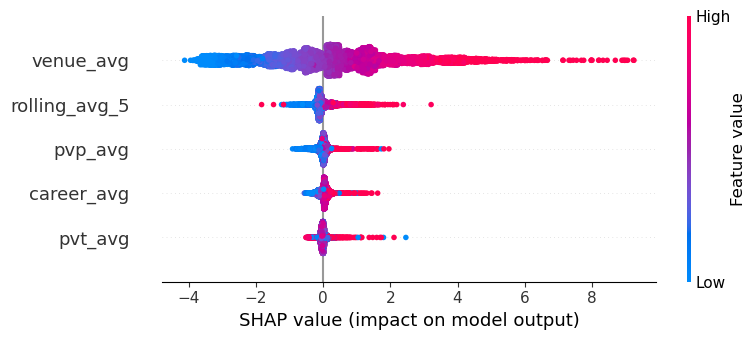

['C:\\Users\\ADMIN\\Desktop\\ipl_score\\scripts\\shap_explainer_batsmen.pkl']

In [20]:
import shap

explainer_runs = shap.Explainer(rf_runs.predict, Xr_train)
shap_values_runs = explainer_runs(Xr_test)
shap.summary_plot(shap_values_runs, Xr_test)

joblib.dump(explainer_runs,r"C:\Users\ADMIN\Desktop\ipl_score\scripts\shap_explainer_batsmen.pkl")

In [21]:
joblib.dump(rf_runs, r"C:\Users\ADMIN\Desktop\ipl_score\scripts\rf_model.joblib")
print("rf_model.joblib saved for runs!")


rf_model.joblib saved for runs!


In [12]:
#wickets---XGBOOST
from sklearn.model_selection import GridSearchCV

param_gridwickets = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05],
    'n_estimators': [200, 300]
}

gridwickets = GridSearchCV(
    XGBRegressor(random_state=42),
    param_gridwickets,
    cv=3,
    scoring='neg_root_mean_squared_error'
)

gridwickets.fit(Xw_train, yw_train)


,estimator,"XGBRegressor(...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.05], 'max_depth': [3, 5, ...], 'n_estimators': [200, 300]}"
,scoring,'neg_root_mean_squared_error'
,n_jobs,None
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'reg:squarederror'


In [13]:
print(gridwickets.best_params_)
print("Best XGBOOST RMSE:", -gridwickets.best_score_)

{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best XGBOOST RMSE: 0.4162977705339106


In [14]:
xgbw.fit(Xw_train, yw_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [ ]:
explainer_wickets = shap.Explainer(xgbw.predict, Xw_train)
shap_values_wickets = explainer_wickets(Xw_test)
shap.summary_plot(shap_values_wickets, Xw_test)

joblib.dump(explainer_wickets,r"C:\Users\ADMIN\Desktop\ipl_score\scripts\shap_explainer_bowler.pkl")

ExactExplainer explainer: 10574it [02:54, 60.49it/s]                                                                   


In [ ]:
joblib.dump(xgbw, r"C:\Users\ADMIN\Desktop\ipl_score\scripts\xgb_model.joblib")
print("xgb_model.joblib saved for wickets!")